数据shape: (8546, 512)
(41, 512)
(41, 512)
count: 776, avg: 80.00443267822266


Text(0.5, 0, '')

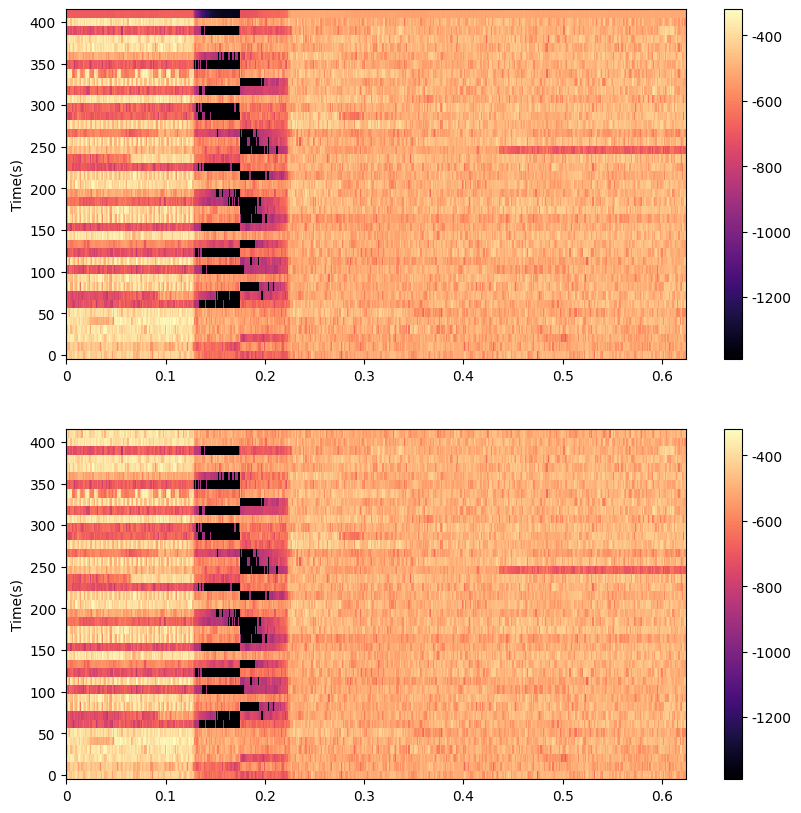

In [35]:
import sys, os
sys.path.append(os.path.join(".."))
sys.path.append(os.path.join("."))

import torch
import matplotlib.pyplot as plt
import librosa.display
from spec_pred.agent_module import SpecModule
from spec_pred.spec_dataset import DataSource, SpecDataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

model_path = "/hdd/1/chenc/lid/speech-lid/spec_pred/outputs/2023-03-24/17-10-CNNLSTM/ckpt/last.pt"
# python main.py --config-name config_cnnlstm model.kernel_size=7 model.dropout=0.5 trainer.total_epoch=5000 data.aug.factor=0.02
model_path = "/hdd/1/chenc/lid/speech-lid/spec_pred/outputs/2023-03-25/21-16-CNNLSTM/ckpt/epoch_1649_val_loss_0.45.pt"

model_path = "/hdd/1/chenc/lid/speech-lid/spec_pred/last.pt"
# python main.py --config-name config_cnnlstm model.kernel_size=7 model.dropout=0.5 trainer.total_epoch=5000 data.aug.factor=0.02
# model_path = "/hdd/1/chenc/lid/speech-lid/spec_pred/outputs/2023-03-26/17-36-CNNLSTM/ckpt/last.pt"
win_len = 40
pred_len = 1
mean = -562.5556880622805
std = 127.53728596715978
# mean = -624.2446584038158
# std = 166.4000655915735
data_path = "/hdd/1/chenc/lid/speech-lid/spec_pred/data/data.json"
device = "cuda:0"
device = torch.device(device)
datasource = DataSource(
    data_path=data_path,
    split=[0.8, 0.1, 0.1],  # [0.8, 0.1, 0.1]
    spec_range=[73456, 73968],  # (73456,73968)
)
test_dataset = SpecDataset(
    train_type="test",
    aug=False,
    datasource=datasource,
    win_len=win_len + pred_len,
)

test_dataset.factor_add()

test_dataset.factor_add()
test_dataset.factor_add()
# test_dataset = SpecDataset(
#     train_type="train",
#     aug=True,
#     datasource=datasource,
#     win_len=win_len + pred_len,
# )
dataloader = DataLoader(
    test_dataset,
    1,
    shuffle=False,
    collate_fn=test_dataset.collate_fn,
    drop_last=False,
)
pred = None
origin = None
total_loss = 0
count = 0
model = SpecModule.resume_from_checkpoint(model_path, map_location=device)
for j in range(win_len):
    for i, batch in enumerate(dataloader):
        x = batch[0]  # B * win_len * D
        y = batch[1]
        y = y * (1e-9 + std) + mean
        origin = x * (1e-9 + std) + mean
        x = x.to(device)
        pred = model.infer(x[:, :win_len, :], win_len, pred_len)
        total_loss += F.l1_loss(y, pred.cpu().squeeze(1))
        count += 1
    test_dataset.factor_add()

pred_graph = torch.cat([origin[0][:win_len,:], pred[0].cpu()]).numpy()
origin = origin[0].cpu().numpy()
print(pred_graph.shape)
print(origin.shape)
print(f"count: {count}, avg: {total_loss/count}")

plt.rcParams["font.sans-serif"]=["STSong"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
sr = pred_graph.shape[0] * 10 * 2
plt.figure(figsize=(10, 10), dpi=100)
plt.subplot(2,1,1)
librosa.display.specshow(pred_graph,sr=sr,x_axis="s", y_axis="hz", hop_length=1)
plt.ylabel("Time(s)")
plt.xlabel("")
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(origin,sr=sr,x_axis="s", y_axis="hz", hop_length=1)
plt.colorbar()
plt.ylabel("Time(s)")
plt.xlabel("")
